# Support Vector Machines
## Course recap
This lab consists in implementing the **Support Vector Machines** (SVM) algorithm. 

Given a training set $ D = \left\{ \left(x^{(i)}, y^{(i)}\right), x^{(i)} \in \mathcal{X}, y^{(i)} \in \mathcal{Y}, i \in \{1, \dots, n \}  \right\}$, where $\mathcal{Y} = \{ 1, \dots, k\}$ . Recall (from lecture 7), SVM aims at minimizing the following cost function $J$:
$$
\begin{split}
J(\theta_1, \theta_2, \dots, \theta_k) 
	&= \sum_{i = 1}^n L_i \\
	&= \sum_{i = 1}^n \sum_{j \neq y_i} \max(0, \theta_j^Tx^{(i)} - \theta_{y^{(i)}}^T x^{(i)} + \Delta)
\end{split}
$$

## Defining the training set
Let us define variables `X` and `Y` that will contain the features $\mathcal{X}$ and labels $\mathcal{Y}$ of the training set. Again, we will be having an intercept $x_0^{(i)}$.

In [1]:
k_classes = 2
X = [[1., 1.5, 0.2], [1., 0.3, 1.2], [1, 1.6, 0.4], [1., 1.3, 0.25], [1., 0.5, 1.12]]
Y = [1, 2, 1, 1, 2]

Let us take a look at the data in 2D (we ignore the intercept which is constantly equal to 1).

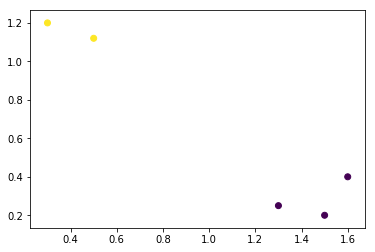

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
X1 = [x[1] for x in X]
X2 = [x[2] for x in X]
plt.scatter(X1, X2, c=Y) # plot x1, x2, color is defined by the label y
plt.show()

The data was generated so that we have two quite distinct classes. This is usually not the case in reality, and for this reason we will see what happens when outliers are implemented (see homework below).

## Prediction function
**Exercise**: Define a function `score` that takes as parameter *the feature vector* $x$ as well as *a model* $\theta$ and outputs the score:
$$ h(x) = \theta^T x = \sum_{j = 0}^d \theta_j x_j$$

In [3]:
def score(x, theta):
    d = len(x)
    thetaTx = 0
    for idx in range(d):
        thetaTx += x[idx] * theta[idx]
    return thetaTx

## Defining the cost function
### Cost function on a single sample
**Exercise**: Define a function `cost_function` that takes as parameter a sample (*the actual label* $y$, the feature vector $x$), the $\theta$s for each classes as well as $\Delta$ and returns the value of the cost function for this sample. 

**Hint**: Recall from lecture 7 that it is given by:
$$ L_i = \sum_{j \neq y_i} \max(0, \theta_j^Tx - \theta_{y}^T x + \Delta) $$

In [4]:
def cost_function(x, y, thetas, delta):
    thetayTx = predict(x, thetas[y])
    loss = 0
    d = len(x)
    for j in range(d):
        if j is not y:
            print("x " + str(x))
            print("thetas " + str(thetas))
            thetajTx = predict(x, thetas[idx])
            loss += max(0, thetajTx - thetayTx + delta)
    return loss

Now we are able to compute the loss for a single training sample, we can get the total cost.

**Exercise**: Define a function `cost_function_total` that will compute the total cost function given by
$$ J = L_i = \sum_{i = 1}^n \sum_{j \neq y_i} \max(0, \theta_j^Tx^{(i)} - \theta_{y^{(i)}}^T x^{(i)} + \Delta) $$

In [5]:
def cost_function_total(X, Y, thetas, delta):
    cost = 0 # initialize the cost with 0
    n = len(Y)
    for i in range(n): # iterate over the training set
        x = X[i] # get the ith feature vector
        y = Y[i] # get the ith label
        cost += cost_function(x, y, thetas, delta) # add the cost of the current sample to the total cost
    return cost

In [6]:
def initialize_thetas(X, k_classes):
    d = len(X[1])
    theta = [0] * d
    return [theta] * k_classes

In [7]:
thetas_0 = initialize_thetas(X, 2)

Recall that the prediction on a feature vector $x$ is given by the value of $j$ that maximizes the score $\theta_j^T x$.

**Exercise**: Define a function `predict` which takes a feature vector `x` as well as the $\theta_j$s and outputs the predicted class $\hat{y}$ which is the value of $j$ maximizing the score.

**Hint**: We have defined a `score` function for this purpose.

In [8]:
def predict(x, thetas):
    k_classes = len(thetas)
    prediction = 0
    highest_score = score(x, thetas[prediction]) # initialize with the first class
    for idx_class in range(k_classes):
        class_score = score(x, thetas[idx_class])
        if class_score > highest_score:
            prediction = idx_class
    return prediction + 1

In [9]:
predict(X[0], thetas_0)

1

## Gradient

We have just defined everything we need to make the prediction and compute the loss for the SVM problem. As usual, we want to minimize this loss. The **gradient descent** works well in this case and in order to apply it, we need to compute the gradient.

Recall that we need to compute a gradient per class as we have $k$ vectors $\theta_j$. The gradient for a sample $x, y$ is given by the following formulas:
- if $j \neq y$:
$$
\nabla_{\theta_j} L = 
	\begin{cases}
	x \quad \text{if} \quad \theta_j^Tx - \theta_{y}^Tx + \Delta > 0 \\
	0 \quad \text{otherwise.}
	\end{cases}
$$
- if $j = y$:
$$
\nabla_{\theta_y} L = px
$$
where $p$ is the **number of times the desired margin is not satisfied**, that is, the number of $j \neq y$ such that $\theta_j^Tx - \theta_{y}^Tx + \Delta > 0$

In [10]:
def gradients(x, y, thetas, delta):
    d = len(x)
    k_classes = len(thetas)
    predicted_class = predict(x, thetas)
    grads = [[0] * d] * k_classes # initialize a list of k_class gradients with zeros everywhere
    for idx_class in range(k_classes): # iterate over all the classes to compute the gradient for each class
        # there are 2 formulas: one for the true class (given by 'y') and another one for the other classes
        if idx_class + 1 == y: # if idx_class is equal to the actual class
            p = 0
            for j in range(k_classes):
                if j + 1 != y: # are counting over the classes different than the actual class
                    if score(x, thetas[j]) - score(x, thetas[y - 1]) + delta > 0:
                        p += 1
            for idx in range(d):
                grads[idx_class][idx] = - p * x[idx]
        else: # if idx_class is not the actual class
            if score(x, thetas[idx_class]) - score(x, thetas[y - 1]) + delta > 0:
                for idx in range(d):
                    grads[idx_class][idx] = x[idx]
            # we do not need an else statement here because the gradient would be equal to 0 in this case, 
            # and the gradient has been initialized with zeros
    return grads

In [11]:
# to delete
print(gradients(X[0], Y[0], thetas_0, 4.0))

[[1.0, 1.5, 0.2], [1.0, 1.5, 0.2]]


The last quantity needed in order to apply the gradient descent is the total gradient (if we want to apply a batch gradient descent, the gradient for a single sample is enough in the stochastic gradient descent case is enough).

To compute it, we just need to sum the gradients for all the samples within the training set.

**Exercise**: Implement a function `gradient_total` that takes as inputs a set of feature vectors $X$, a set of labels $Y$, values for the $\theta_j$s as well as the hyperparamter $\Delta$ and outputs the gradient of $J$.

In [12]:
# For the sake of clarity, we first define a function that sums vectors elementwise
def sum_vectors(x1, x2):
    d = len(x1)
    sum_vector = x1
    for idx in range(d):
        sum_vector[idx] += x2[idx]
    return sum_vector

def gradient_total(X, Y, thetas, delta):
    n = len(Y) # number of training samples
    d = len(X[1])
    k_classes = len(thetas)
    grads_sum = [[0] * d] * k_classes 
    for i in range(n):
        x = X[i]
        y = Y[i]
        grads = gradients(x, y, thetas, delta) # get the gradient for the current sample
        for j in range(k_classes):
            grads_sum[j] = sum_vectors(grads[j], grads_sum[j]) # add it to the total gradients
    return grads_sum

In [13]:
# to delete
gradient_total(X, Y, thetas_0, 4.0)

[[13.0, 30.1, -5.420000000000001], [13.0, 30.1, -5.420000000000001]]

Now that we have the gradient, we can apply the gradient descent algorithm.

**Exercise**: Implement a function `gradient_descent` that takes as parameter the training set $(X, Y)$, the hyperparameter $\Delta$ as well as a learning rate and applied the gradient descent algorithm to the SVM case.

**Hint**: Feel free to get back to the lectures to recall the gradient descent update.

In [14]:
# For the sake of readability, we define a function axpb (that stands for a x plus b) that outputs a * x + b 
# where a is a scalar and x and b are vectors
def axpb(a, x, b):
    # x and b should have the same size, a is a scalar
    d = len(x)
    sum_vector = b
    for idx in range(d):
        sum_vector[idx] += a * x[idx]
    return sum_vector

def gradient_descent(X, Y, delta, learning_rate):
    k_classes = len(set(Y))
    thetas = initialize_thetas(X, k_classes)
    for i_iter in range(5):
        grads = gradient_total(X, Y, thetas, delta)
        for j in range(k_classes):
            thetas[j] = axpb(-learning_rate, grads[j], thetas[j])
        print("X " + str(X))
        cost = cost_function_total(X, Y, thetas, delta)
        print("iteration " + str(i_iter) + ", cost = " + str(cost))
    return thetas

## Homework
At this point, you should be able to guess the questions for the homework and solve them.
As for the OLS case, the questions are:
- Define initial vectors $\theta_j$s (for example with only zeros) and apply the gradient descent to the simple data set we have defined above. Do not forget to play with the learning rate and well as $\Delta$
- Do the same with the stochastic gradient descent version.
- Observe how the space is partitionned after having trained the SVM model.
- For both solutions above, observe the loss function in 2D, and observe the path followed by the $\theta$ values over time.
- What does an outlier look like in the classification case? Add an outlier to the training set, and run the SVM algorithm to it. What issue do we observe? Propose a solution to overcome this issue and implement it.